In [1]:
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from transformers import AutoModel, AutoTokenizer

from datasets import load_dataset
from nltk.tokenize import ToktokTokenizer, TweetTokenizer
from sklearn.metrics import f1_score
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import re
from itertools import groupby
from collections import Counter

from sklearn.metrics import classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay, roc_curve, auc

# Deep Average Network для определения сентимента 

В этой домашке мы будет классифицировать твиты на 3 тональности.  
Вы будете использовать предобученные эмбеддинги слов, так что для начала обязательно нужно посмотреть [туториал по их использованию](https://github.com/BobaZooba/DeepNLP/blob/master/Tutorials/Word%20vectors%20%26%20Data%20Loading.ipynb).

Наши классы:  

Индекс | Sentiment  
-- | --  
0 | negative  
1 | neutral  
2 | positive  

Вам предстоит реализовать такую модель:
![Архитектура модели DAN](https://www.researchgate.net/profile/Shervin-Minaee/publication/340523298/figure/fig1/AS:878252264550411@1586403065555/The-architecture-of-the-Deep-Average-Network-DAN-10.ppm)

Что она из себя представляет:
- Мы подаем в нее индексы слов
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`

В этой домашке вам предстоит:
- Перевести тексты в матрицы с индексами токенов
- Реализовать модель
- Обучить ее
- Понять хорошо ли вы это сделали

Это очень важная модель, потому что она очень простая и показывает достаточно высокие метрики. В дальнейшем на работе советую использовать такую модель как бейзлайн. И в качестве эмбеддингов слов взять эмбеддинги от берта/роберты/тд.

## 🤗 Datasets
В этом туториале мы будем использовать подготовленные данные из библиотеки [datasets](https://github.com/huggingface/datasets). Мы вряд ли еще будем пользоваться этой библиотекой, так как нам будет важно самим подготавливать данные. Во-первых, для простоты, во-вторых, здесь есть достаточно неплохие практики. [Здесь](https://huggingface.co/datasets) вы сможете найти достаточно большое количество различных датасетов. Возможно, когда-нибудь они вам пригодятся.

## Загрузите эмбеддинги слов
Реализуйте функцию по загрузке эмбеддингов из файла. Она должна отдавать словарь слов и `np.array`
Формат словаря:
```python
{
    'aabra': 0,
    ...,
    'mom': 6546,
    ...
    'xyz': 100355
}
```
Формат матрицы эмбеддингов:
```python
array([[0.44442278, 0.28644582, 0.04357426, ..., 0.9425766 , 0.02024289,
        0.88456545],
       [0.77599317, 0.35188237, 0.54801261, ..., 0.91134102, 0.88599103,
        0.88068835],
       [0.68071886, 0.29352313, 0.95952505, ..., 0.19127958, 0.97723054,
        0.36294011],
       ...,
       [0.03589378, 0.85429694, 0.33437761, ..., 0.39784873, 0.80368014,
        0.76368042],
       [0.01498725, 0.78155695, 0.80372969, ..., 0.82051826, 0.42314861,
        0.18655465],
       [0.69263802, 0.82090775, 0.27150426, ..., 0.86582747, 0.40896573,
        0.33423976]])
```

Количество строк в матрице эмбеддингов должно совпадать с размером словаря, то есть для каждого токена должен быть свой эмбеддинг. По параметру `num_tokens` должно брать не более указано в этом параметре количество токенов в словарь и матрицу эмбеддингов.

In [2]:
def load_embeddings(path, pad_token='PAD', unk_token='UNK', num_tokens=100_000, verbose=True):
    """
    
    """
    token2index: Dict[str, int] = {}
    embeddings:  List[str]      = []
    
    with open(path, encoding='utf-8') as file_object:

        vocab_size, embedding_dim = file_object.readline().strip().split()

        vocab_size = int(vocab_size)
        embedding_dim = int(embedding_dim)

        num_tokens = vocab_size if num_tokens <= 0 else num_tokens

        # добавим пад токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
        token2index[pad_token] = 0
        embeddings.append(np.zeros(embedding_dim))

        # добавим унк токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
        token2index[unk_token] = 1
        embeddings.append(np.ones(embedding_dim))

        progress_bar = tqdm(total=num_tokens, disable=not verbose, desc='Reading embeddings file')

        for line in file_object:
            parts = line.strip().split()

            token = ' '.join(parts[:-embedding_dim]).lower()

            if token in token2index:
                continue

            word_vector = np.array(list(map(float, parts[-embedding_dim:])))

            token2index[token] = len(token2index)
            embeddings.append(word_vector)

            progress_bar.update()

            if len(token2index) == num_tokens:
                break

        progress_bar.close()
        
    embeddings_matrix: np.array = np.array(embeddings)
    
    assert(len(token2index) == embeddings_matrix.shape[0])
    
    return token2index, embeddings_matrix

## Загружаем данные из библиотеки
Мы сразу получим `torch.utils.data.Dataset`, который сможем передать в `torch.utils.data.DataLoader`

In [3]:
dataset_path = "tweet_eval"
dataset_name = "sentiment"

train_dataset = load_dataset(path=dataset_path, name=dataset_name, split="train")
valid_dataset = load_dataset(path=dataset_path, name=dataset_name, split="validation")
test_dataset = load_dataset(path=dataset_path, name=dataset_name, split="test")

Reusing dataset tweet_eval (C:\Users\adugeen\.cache\huggingface\datasets\tweet_eval\sentiment\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (C:\Users\adugeen\.cache\huggingface\datasets\tweet_eval\sentiment\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (C:\Users\adugeen\.cache\huggingface\datasets\tweet_eval\sentiment\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


## `torch.utils.data.DataLoader`

In [4]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

## Посмотрим что отдает нам `Loader`
Это батч формата:
```python
batch = {
    "text": [
        "text1",
        "text2",
        ...,
        "textn"
    ],
    "label": tensor([
        1,
        1,
        ...,
        0
    ])
}
```
То есть у нас есть словарь с двумя ключами `text` и `label`, где хранится n примеров. То есть для 5-го примера в батче текст будет храниться в `batch["text"][5]`, а индекс класса будет храниться в `batch["label"][5]`.

In [5]:
for batch in train_loader:
    break

batch

{'text': ["@user Oooh. Haha. Well unfortunately I really shouldn't watch another tonight. Although I might. But it'd be Blue which will make me",
  'Wow\\u002c what a weekend: Flying Lotus\\u002c Zombie Apocalypse\\u002c writing\\u002c Patriots\\u002c Dog Beach...goodnight everyone. Monday morning\\u002c screw you.'],
 'label': tensor([0, 2])}

## Collate
Сейчас перед нами стоит проблема: мы получаем тексты в виде строк, а нам нужны тензоры (матрицы) с индексами токенов, к тому же нам нужно западить последовательности токенов, чтобы все сложить в торчовую матрицу. Мы можем сделать это двумя способами:
- Достать из `train/valid/test_dataset` данные и написать свой `Dataset`, где внутри будет токенизировать текст, токены будут переводиться в индексы и затем последовательность будет падиться до нужной длины
- Сделать функцию, которая бы дополнительно обрабатывали наши батчи. Она вставляется в `DataLoader(collate_fn=<ВАША_ФУНКЦИЯ>)`

## Если вы хотите сделать свой `Dataset`
То вы можете достать данные таким образом.

In [6]:
len(train_dataset["text"]), len(train_dataset["label"])

(45615, 45615)

In [7]:
train_dataset["text"][:2]

['"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"',
 '"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"']

In [8]:
train_dataset["label"][:2]

[2, 1]

## Если вы хотите сделать `collate_fn`

### Давайте посмотрим что вообще происходит внутри этого метода
Для этого сделаем функцию `empty_collate`, которая принимает на вход батч и отдает его, ничего с ним не делая

In [9]:
def empty_collate(batch):
    return batch

In [10]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=empty_collate)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)

In [11]:
for batch in train_loader:
    break

batch

[{'text': '"Praise the sun, Dark Souls 3 stress test sign-ups are open',
  'label': 1},
 {'text': '"Saturday Night Observation: I\'m really surprised Seth Rollins never ""had to"" change his hair style after winning the World Title."',
  'label': 1}]

## Формат батча
```python
batch = [
    {
        "text": "text1",
        "label": 0
    }, 
    {
        "text": "text2",
        "label": 1
    },
    ...,
    {
        "text": "textn",
        "label": 1
    }
]
```
То есть теперь у нас есть список, где каждый элемент — это словарь со значениями `text` и `label`.  

Вы можете сделать функцию или класс с методом `collate`. Этот способ решения домашки предодчтительней, так как использовать `collate` очень хорошая практика.

Что я предлагаю:
- Сделайте класс `Tokenizer`

In [12]:
stop_symbols = '@."\'$№'

class Tokenizer:
    
    def __init__(self, 
                 base_tokenizer, 
                 token2index, 
                 pad_token='PAD', unk_token='UNK', 
                 max_length=64, ):
        
        self._base_tokenizer = base_tokenizer  # например ToktokTokenizer()
        
        self.token2index = token2index  # словарь из load_embeddings()
        
        self.pad_token = pad_token
        self.pad_index = self.token2index[self.pad_token]
        
        self.unk_token = unk_token
        self.unk_index = self.token2index[self.unk_token]
        
        self.max_length = max_length

    def tokenize(self, text):
        """
        В этом методе нужно разделить строку текста на токены
        """
        return self._base_tokenizer.tokenize(text)
    
    def indexing(self, tokenized_text):
        """
        В этом методе нужно перевести список токенов в список с индексами этих токенов
        """
        return [self.token2index.get(token, self.unk_index) for token in tokenized_text]
        
    def padding(self, tokens_indices):
        """
        В этом методе нужно сделать длину tokens_indices равной self.max_length
        Опционально убрать повторяющиеся unk'и
        """
        # Убираем повторяющиеся токены, оставляя 1 токен unk в последовательности
        tokens_indices = [token for token in tokens_indices if len(token) > 1]
        tokens_indices = [token for token, group in groupby(tokens_indices)]
        return tokens_indices[:self.max_length] + [self.pad_token] * (self.max_length - len(tokens_indices))
    
    def __call__(self, text):
        """
        В этом методе нужно перевести строку с текстом в вектор с индексами слов нужно размера (self.max_length)
        """
        preprocessed_text = text
        preprocessed_text = re.sub(f'[{stop_symbols}]', '', preprocessed_text)
        preprocessed_text = re.sub(r'@[Uu]ser', '', preprocessed_text)
        preprocessed_text = re.sub(r'\s+', ' ', preprocessed_text)
        return self.indexing(self.padding(self.tokenize(preprocessed_text)))
        
    def collate(self, batch):
        
        tokenized_texts = list()
        labels = list()
        
        for sample in batch:
            tokenized_texts.append(self(sample['text']))
            labels.append(sample['label'])
            
        tokenized_texts = torch.LongTensor(tokenized_texts)  # перевод в torch.Tensor
        labels = torch.LongTensor(labels)  # перевод в torch.Tensor
        
        return tokenized_texts, labels

## Перед реализацией выбранного метода
Советую, чтобы в итоге `Loader` отдавал кортеж с двумя тензорами:
- `torch.Tensor` с индексами токенов, размерность `(batch_size, sequence_length)`
- `torch.Tensor` с индексами таргетов, размерность `(batch_size)`

То есть, чтобы было так:
```python
for x, y in train_loader:
    ...

>> x
>> tensor([[   37,  3889,   470,  ...,     0,     0,     0],
           [ 1509,   581,   144,  ...,     0,     0,     0],
           [ 1804,   893,  2457,  ...,     0,     0,     0],
           ...,
           [  170, 39526,  2102,  ...,     0,     0,     0],
           [ 1217,   172, 28440,  ...,     0,     0,     0],
           [   37,    56,   603,  ...,     0,     0,     0]])

>> y
>> tensor([1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 1,
           0, 2, 1, 1, 0, 1, 2, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0,
           1, 0, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 0, 1, 0, 2, 1, 2, 2, 1, 0, 0, 2, 2,
           2, 1, 2, 0, 2, 2, 0, 2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, 2, 2,
           2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 1,
           2, 1, 1, 2, 2, 1, 1, 2])

>> x.shape
>> torch.Size([128, 64])

>> y.shape
>> torch.Size([128])
```
При условии, что батч сайз равен 128, а максимальная длина последовательности равна 64.

## Помните

## <Место для реализации>

In [13]:
bert_tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
bert = AutoModel.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")

emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji
Some weights of the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis were not used when initializing RobertaModel: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis and are newly initialized: ['roberta.pooler.dense.wei

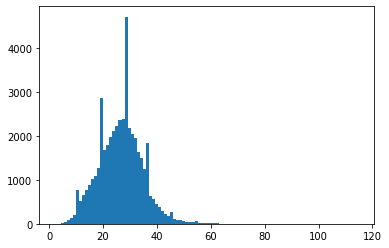

In [14]:
tokens = [bert_tokenizer.tokenize(text) for text in train_dataset['text']]
len_tokens = [len(token) for token in tokens]
plt.hist(len_tokens, bins=100)
plt.show()

In [15]:
#vocab, embeddings = load_embeddings('cc.en.300.vec', verbose=False)
embeddings = bert.embeddings.word_embeddings.weight
tokenizer = Tokenizer(bert_tokenizer, 
                      bert_tokenizer.get_vocab(), 
                      bert_tokenizer.pad_token, 
                      bert_tokenizer.unk_token, 
                      int(np.quantile(len_tokens, 0.99)),
                      )

train_loader = DataLoader(train_dataset, batch_size=train_dataset.num_rows // 100, shuffle=True, collate_fn=tokenizer.collate)
valid_loader = DataLoader(valid_dataset, batch_size=50, shuffle=False, collate_fn=tokenizer.collate)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False, collate_fn=tokenizer.collate)

In [16]:
for x, y in train_loader:
    break

In [17]:
assert(isinstance(x, torch.Tensor))
assert(len(x.size()) == 2)

assert(isinstance(y, torch.Tensor))
assert(len(y.size()) == 1)

# Реализация DAN

На вход модели будут подавать индексы слов

Шаги:
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`
    - Нужно реализовать самому

### Что нужно сделать в домашке с точки зрения архитектуры сети:
- Реализовать skip-connection (residual connection) в линейном слое
- Написать свой слой, в котором будут (порядок слоев ниже напутан, так что сами подумайте в каком порядке стоит расположить эти слои) :
  - `Dropout`
  - `BatchNorm` / `LayerNorm`
  - `Residual`, если вы не меняете размерность векторов
  - Функция активации
  - Линейный слой

### Опциональные задания:
- Использовать токенизатор и слой эмбеддингов от предобученного трансформера из библиотеки `transformers`
- Сделать усреднение эмбеддингов с учетом падов
  - Мы используем пады, чтобы сделать единую длину последовательностей в батче
    - То есть у нас максимальная длина в батче, например, 16 токенов, поэтому ко всем последовательностям, у которых длина ниже мы добавляем `16 - len(sequence)` падов
  - То есть получается так, что усредненный вектор предложения зависит от максимальный длины в батче, потому что
    - Среднее вектора `[1, 2, 3]` будет `2`. Среднее вектора `[1, 2, 3, 0, 0]` будет `1.2`
    - Получается, что усредняя с падами мы получаем "неправильный" вектор
  - То есть наши предсказания будут зависеть от того сколько падов у нас есть в предложении
  - Когда мы будем использовать нашу сетку в реальном процессе, скорее всего, мы будем подавать в нее по одному примеру, где падов не будет
    - То есть получается мы будем использовать нашу модель не в той же среде, как и обучали
      - Потому что наши входы меняются, мы не используем пады, результат усреднения другой
    - Это называется `distribution shift`, то есть когда мы учимся на одних данных, а используем на других
      - Это не всегда плохо, потому что иногда только так мы и можем учиться, например, когда мало данных нужного домена
      - Это плохо тогда, когда мы вносим это "случайно", например, как с неправильным усреднением, то есть это своебразный баг


## До обучения
- Выберите метрику(ки) качества и расскажите почему она(они)
    - Обычно есть основная метрика, по которой принимаем решения какие веса брать и дополнительные, которые нам помогут делать выводы, например, о том все ли хорошо с нашими данными, хорошо ли модель справляется с дисбалансом классов и тд
- Эту домашку можно сделать и на `CPU`, но на `GPU` будет сильно быстрее
    - Во всех остальных домашках мы будем учить модели на `GPU`
    - Рано или поздно вам придется посмотреть этот [туториал](https://www.youtube.com/watch?v=pgk1zGv5lU4)
    - Вы можете обучаться на `colab`, это бесплатно

## До эпохи
- Сделайте списки/словари/другое, чтобы сохранять нужные данные для расчета метрик(и) по всей эпохе для трейна и валидации

## Во время эпохи
- Используйте [`tqdm`](https://github.com/tqdm/tqdm) как прогресс бар, чтобы понимать как проходит ваше обучение
- Логируйте лосс
- Логируйте метрику(ки) по батчу
- Сохраняйте то, что вам нужно, чтобы посчитать метрик(и) на всю эпоху для трейна и валидации

## После эпохи
- Посчитайте метрик(и) на всю эпоху для трейна и валидации

## После обучения
- Провалидируйтесь на тестовом наборе и посмотрите метрики
- Постройте [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
- Постройте графики:
    - [Confusion Matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)
    - [Опционально] Распределение вероятностей мажоритарного класса (то есть для какого-то примера мы выбираем такой класс и вероятность этого выбора такая-то) на трейне/тесте/валидации
        - Если класс был выбран верно и если была ошибка
- Подумайте что еще вам будет полезно для того, чтобы ответить на такие вопросы: 
    - Что в моделе можно улучшить?
    - Все ли хорошо с моими данными?
    - Все ли хорошо с валидацией?
    - Не переобучился ли я?
    - Достаточно ли я посмотрел на данные?
    - Нужно ли мне улучшить предобработку данных?
    - Нужно ли поменять токенизацию или эмбеддинги?
    - Нет ли у меня багов в реализации?
    - Какие типичные ошибки у моей модели?
    - Как я могу их исправить?

# Я выбрал метрику f1-score

> Это моя метрика. Таких метрик много, но эта моя. Моя метрика — мой лучший друг. Это — моя жизнь. Я должен научиться владеть метрикой так же, как владею своей жизнью. Без меня моя метрика бесполезна. Без моей метрики бесполезен я. Я должен метко обучать модель на оптимизацию моей метрики. Я должен обучать точнее, чем конкурент, который пытается меня обойти. Я должен обучить модель лучше до того, как он обучит свою. И я это сделаю. Клянусь перед тим лидом. Я и моя метрика — мы защитники моей галеры. Мы не боимся конкурентов. Мы спасители ROI нашего отдела. Пусть будет так. Пока не останется больше конкурентов и не наступит эпоха AGI. Трансформер.

Почему я выбрал эту метрику:

f1-score, в частности macro, позволяет более адекватно оценивать ситуации, когда наблюдается дисбаланс классов. Предварительный анализ данных показал, что дисбаланс есть. На её основе можно будет понять, каким классам нужно давать веса.

In [18]:
class SkipConnectionLayer(nn.Module):
    
    def __init__(self, in_features, hidden_features):

        # Вызываем __init__ родителя - torch.nn.Module
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # определяем слои и все что захотим сохранять/использовать
        self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=hidden_features)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=hidden_features, out_features=hidden_features)
        self.relu_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(in_features=hidden_features, out_features=in_features)
        self.relu_3 = torch.nn.ReLU()

    def forward(self, x):
        residual = x.clone()
        
        x = self.relu_1(self.linear_1(x))
        x = self.relu_2(self.linear_2(x))
        x = self.relu_3(self.linear_3(x))
        x = x + residual

        return x

In [19]:
class DeepAverageNetwork(nn.Module):
    
    def __init__(self, 
                 embeddings,
                 hidden_features=128,
                 p_dropout=0.2,
                 n_classes=3):

        # Вызываем __init__ родителя - torch.nn.Module
        super().__init__()
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
            embeddings = embeddings.cuda()
        else:
            self.device = torch.device('cpu')

        # определяем слои и все что захотим сохранять/использовать
        self.embeddings = torch.nn.Embedding.from_pretrained(embeddings)
        self.relu = torch.nn.ReLU()
        self.linear = torch.nn.Linear(in_features=embeddings.shape[1], out_features=n_classes).cuda()
        self.softmax = torch.nn.Softmax(1)
        self.batch_norm = torch.nn.BatchNorm1d(embeddings.shape[1])
        self.dropout = torch.nn.Dropout(p_dropout)
        self.relu_out = torch.nn.ReLU()
        self.residual_layer = SkipConnectionLayer(in_features=embeddings.shape[1], hidden_features=hidden_features)

    def forward(self, x):
        x = self.embeddings(x)
        x = x.sum(1)
        x /= x.shape[1]
        x = self.residual_layer(x)
        x = self.dropout(x)
        x = self.batch_norm(x)
        x = self.linear(x)
        x = self.softmax(x)
        
        return x

## Задайте функцию потерь и оптимизатор

In [20]:
model = DeepAverageNetwork(embeddings, 512, 0.5)

weights = [train_dataset['label'].count(label) for label in np.unique(train_dataset['label'])]
weights = 1 - (weights / np.sum(weights))

criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weights))
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00001)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

## Сделайте цикл обучения

In [21]:
def get_distributions(distributions_dict, stage, pred, y):
    for p, pred_idx, y_idx in zip(pred.max(axis=1).values.detach().numpy(), pred.max(axis=1).indices.numpy(), y.numpy()):
        if pred_idx == y_idx:
            distributions_dict['true'][pred_idx].append(p)
        else:
            distributions_dict['false'][pred_idx].append(p)

In [22]:
NUM_EPOCHS = 100 # Задайте количество эпох
LAG_PARAM = 3
lag = 0

losses   = []

f1_train = []
f1_valid = []

t_losses = []
v_losses = []

distributions = {}
best_valid_loss = np.finfo(np.float).max


for n_epoch in range(NUM_EPOCHS):
    train_losses  = []
    train_prob    = {'true': [[], [], []], 'false': [[], [], []]}
    train_preds   = []
    train_targets = []
    valid_losses  = []
    valid_prob    = {'true': [[], [], []], 'false': [[], [], []]}
    valid_preds   = []
    valid_targets = []
    
    model.train()
    for x, y in tqdm(train_loader):
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
        
        optimizer.zero_grad()
        
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()

        optimizer.step()

        train_preds.append(pred.detach().cpu().numpy())
        train_targets.append(y.cpu().numpy())
        
        current_loss_value = loss.item()
        train_losses.append(current_loss_value)
        losses.append(current_loss_value)
        
        get_distributions(train_prob, 'train', pred.cpu(), y.cpu())
        
    model.eval()
    for x, y in valid_loader:
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
        
        with torch.no_grad():
            
            pred = model(x)
            
        valid_preds.append(pred.cpu().numpy())
        valid_targets.append(y.cpu().numpy())

        loss = criterion(pred, y)

        valid_losses.append(loss.item())
        
        get_distributions(valid_prob, 'valid', pred.cpu(), y.cpu())
        
    mean_train_loss = np.mean(train_losses)
    mean_valid_loss = np.mean(valid_losses)
        
    t_losses.append(mean_train_loss)
    v_losses.append(mean_valid_loss)
        
    print('Losses: train - {:.3f}, valid = {:.3f}'.format(np.mean(train_losses), mean_valid_loss))
    
    train_preds = np.concatenate(train_preds)
    train_preds = train_preds.argmax(axis=1)
    train_targets = np.concatenate(train_targets)
    
    valid_preds = np.concatenate(valid_preds)
    valid_preds = valid_preds.argmax(axis=1)
    valid_targets = np.concatenate(valid_targets)
    
    train_score = f1_score(train_targets, train_preds, average='macro')
    valid_score = f1_score(valid_targets, valid_preds, average='macro')
    
    f1_train.append(train_score)
    f1_valid.append(valid_score)
    
    print('Valid: f1-score - {:.3f}'.format(valid_score))
        
    # early stopping
    # то есть: если наша функция потерь на валидационном датасете стала расти, то прекращаем обучение
    # рост фунции потерь на валидационном датасете говорит о переобучении
    if mean_valid_loss < best_valid_loss:
        best_valid_loss = mean_valid_loss
        lag = 0
    elif lag == LAG_PARAM:
        print('Early stopping')
        break    
    lag += 1
    

test_preds   = []
test_targets = []
test_losses  = []
test_prob    = {'true': [[], [], []], 'false': [[], [], []]}
model.eval()
for x, y in test_loader:
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()
    
    with torch.no_grad():

        pred = model(x)

    test_preds.append(pred.cpu().numpy())
    test_targets.append(y.cpu().numpy())

    loss = criterion(pred, y)

    test_losses.append(loss.item())
    get_distributions(test_prob, 'test', pred.cpu(), y.cpu())

test_preds = np.concatenate(test_preds).argmax(axis=1)
test_targets = np.concatenate(test_targets)

distributions['train'] = train_prob
distributions['valid'] = valid_prob
distributions['test']  = test_prob

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:40<00:00,  2.50it/s]


Losses: train - 1.104, valid = 1.098
Valid: f1-score - 0.269


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  3.01it/s]


Losses: train - 1.103, valid = 1.095
Valid: f1-score - 0.324


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.87it/s]


Losses: train - 1.101, valid = 1.093
Valid: f1-score - 0.308


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:34<00:00,  2.92it/s]


Losses: train - 1.100, valid = 1.093
Valid: f1-score - 0.351


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:30<00:00,  3.34it/s]


Losses: train - 1.097, valid = 1.092
Valid: f1-score - 0.395


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:34<00:00,  2.93it/s]


Losses: train - 1.095, valid = 1.092
Valid: f1-score - 0.391


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:34<00:00,  2.90it/s]


Losses: train - 1.094, valid = 1.089
Valid: f1-score - 0.390


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:34<00:00,  2.91it/s]


Losses: train - 1.093, valid = 1.088
Valid: f1-score - 0.357


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.86it/s]


Losses: train - 1.090, valid = 1.089
Valid: f1-score - 0.383


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.84it/s]


Losses: train - 1.088, valid = 1.088
Valid: f1-score - 0.382


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.84it/s]


Losses: train - 1.086, valid = 1.087
Valid: f1-score - 0.404


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:34<00:00,  2.90it/s]


Losses: train - 1.085, valid = 1.082
Valid: f1-score - 0.409


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.88it/s]


Losses: train - 1.082, valid = 1.081
Valid: f1-score - 0.423


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:34<00:00,  2.89it/s]


Losses: train - 1.080, valid = 1.078
Valid: f1-score - 0.410


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:34<00:00,  2.90it/s]


Losses: train - 1.076, valid = 1.077
Valid: f1-score - 0.414


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.88it/s]


Losses: train - 1.073, valid = 1.072
Valid: f1-score - 0.417


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.86it/s]


Losses: train - 1.069, valid = 1.070
Valid: f1-score - 0.451


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.87it/s]


Losses: train - 1.063, valid = 1.065
Valid: f1-score - 0.455


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.88it/s]


Losses: train - 1.059, valid = 1.062
Valid: f1-score - 0.463


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.86it/s]


Losses: train - 1.054, valid = 1.059
Valid: f1-score - 0.460


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:34<00:00,  2.91it/s]


Losses: train - 1.050, valid = 1.052
Valid: f1-score - 0.448


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.88it/s]


Losses: train - 1.044, valid = 1.049
Valid: f1-score - 0.452


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.85it/s]


Losses: train - 1.040, valid = 1.044
Valid: f1-score - 0.454


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.87it/s]


Losses: train - 1.034, valid = 1.041
Valid: f1-score - 0.460


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.87it/s]


Losses: train - 1.030, valid = 1.037
Valid: f1-score - 0.462


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.86it/s]


Losses: train - 1.024, valid = 1.031
Valid: f1-score - 0.463


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.85it/s]


Losses: train - 1.020, valid = 1.024
Valid: f1-score - 0.456


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:34<00:00,  2.90it/s]


Losses: train - 1.014, valid = 1.020
Valid: f1-score - 0.472


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:32<00:00,  3.07it/s]


Losses: train - 1.010, valid = 1.018
Valid: f1-score - 0.482


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.82it/s]


Losses: train - 1.005, valid = 1.010
Valid: f1-score - 0.478


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.83it/s]


Losses: train - 1.000, valid = 1.007
Valid: f1-score - 0.494


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  3.04it/s]


Losses: train - 0.995, valid = 1.004
Valid: f1-score - 0.490


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:34<00:00,  2.90it/s]


Losses: train - 0.990, valid = 0.997
Valid: f1-score - 0.496


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.87it/s]


Losses: train - 0.987, valid = 0.994
Valid: f1-score - 0.496


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.84it/s]


Losses: train - 0.982, valid = 0.988
Valid: f1-score - 0.495


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.81it/s]


Losses: train - 0.979, valid = 0.985
Valid: f1-score - 0.492


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  3.01it/s]


Losses: train - 0.974, valid = 0.982
Valid: f1-score - 0.506


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  2.97it/s]


Losses: train - 0.971, valid = 0.977
Valid: f1-score - 0.504


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:36<00:00,  2.77it/s]


Losses: train - 0.969, valid = 0.975
Valid: f1-score - 0.513


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.83it/s]


Losses: train - 0.966, valid = 0.972
Valid: f1-score - 0.514


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.87it/s]


Losses: train - 0.962, valid = 0.969
Valid: f1-score - 0.526


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.81it/s]


Losses: train - 0.960, valid = 0.965
Valid: f1-score - 0.526


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.85it/s]


Losses: train - 0.957, valid = 0.963
Valid: f1-score - 0.525


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:36<00:00,  2.79it/s]


Losses: train - 0.954, valid = 0.966
Valid: f1-score - 0.544


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.82it/s]


Losses: train - 0.951, valid = 0.960
Valid: f1-score - 0.547


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:36<00:00,  2.79it/s]


Losses: train - 0.949, valid = 0.955
Valid: f1-score - 0.547


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.81it/s]


Losses: train - 0.947, valid = 0.955
Valid: f1-score - 0.549


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:36<00:00,  2.80it/s]


Losses: train - 0.945, valid = 0.955
Valid: f1-score - 0.542


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.81it/s]


Losses: train - 0.943, valid = 0.948
Valid: f1-score - 0.554


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.82it/s]


Losses: train - 0.942, valid = 0.949
Valid: f1-score - 0.547


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:36<00:00,  2.80it/s]


Losses: train - 0.940, valid = 0.949
Valid: f1-score - 0.562


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:36<00:00,  2.79it/s]


Losses: train - 0.939, valid = 0.943
Valid: f1-score - 0.566


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.82it/s]


Losses: train - 0.935, valid = 0.944
Valid: f1-score - 0.551


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:36<00:00,  2.78it/s]


Losses: train - 0.935, valid = 0.942
Valid: f1-score - 0.571


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.87it/s]


Losses: train - 0.934, valid = 0.941
Valid: f1-score - 0.553


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:35<00:00,  2.85it/s]


Losses: train - 0.931, valid = 0.938
Valid: f1-score - 0.558


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:34<00:00,  2.94it/s]


Losses: train - 0.929, valid = 0.946
Valid: f1-score - 0.557


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  3.04it/s]


Losses: train - 0.928, valid = 0.933
Valid: f1-score - 0.563


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:34<00:00,  2.90it/s]


Losses: train - 0.924, valid = 0.931
Valid: f1-score - 0.575


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:34<00:00,  2.95it/s]


Losses: train - 0.924, valid = 0.932
Valid: f1-score - 0.577


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:34<00:00,  2.90it/s]


Losses: train - 0.922, valid = 0.931
Valid: f1-score - 0.576


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:34<00:00,  2.90it/s]


Losses: train - 0.922, valid = 0.929
Valid: f1-score - 0.578


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:18<00:00,  5.56it/s]


Losses: train - 0.919, valid = 0.928
Valid: f1-score - 0.569


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.76it/s]


Losses: train - 0.919, valid = 0.926
Valid: f1-score - 0.579


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.78it/s]


Losses: train - 0.917, valid = 0.926
Valid: f1-score - 0.576


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.74it/s]


Losses: train - 0.915, valid = 0.922
Valid: f1-score - 0.577


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:16<00:00,  6.04it/s]


Losses: train - 0.915, valid = 0.920
Valid: f1-score - 0.592


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:18<00:00,  5.54it/s]


Losses: train - 0.912, valid = 0.921
Valid: f1-score - 0.582


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.75it/s]


Losses: train - 0.913, valid = 0.918
Valid: f1-score - 0.589


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.89it/s]


Losses: train - 0.912, valid = 0.920
Valid: f1-score - 0.587


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:18<00:00,  5.43it/s]


Losses: train - 0.910, valid = 0.916
Valid: f1-score - 0.589


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.65it/s]


Losses: train - 0.909, valid = 0.918
Valid: f1-score - 0.596


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.73it/s]


Losses: train - 0.907, valid = 0.919
Valid: f1-score - 0.592


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.90it/s]


Losses: train - 0.907, valid = 0.911
Valid: f1-score - 0.585


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.71it/s]


Losses: train - 0.906, valid = 0.915
Valid: f1-score - 0.586


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.82it/s]


Losses: train - 0.903, valid = 0.916
Valid: f1-score - 0.591


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.62it/s]


Losses: train - 0.902, valid = 0.908
Valid: f1-score - 0.596


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.74it/s]


Losses: train - 0.901, valid = 0.908
Valid: f1-score - 0.600


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.88it/s]


Losses: train - 0.901, valid = 0.909
Valid: f1-score - 0.603


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:18<00:00,  5.56it/s]


Losses: train - 0.900, valid = 0.912
Valid: f1-score - 0.597


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.72it/s]


Losses: train - 0.898, valid = 0.905
Valid: f1-score - 0.597


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:18<00:00,  5.44it/s]


Losses: train - 0.898, valid = 0.903
Valid: f1-score - 0.599


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:18<00:00,  5.57it/s]


Losses: train - 0.897, valid = 0.919
Valid: f1-score - 0.592


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:18<00:00,  5.60it/s]


Losses: train - 0.896, valid = 0.902
Valid: f1-score - 0.601


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.64it/s]


Losses: train - 0.895, valid = 0.902
Valid: f1-score - 0.609


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.65it/s]


Losses: train - 0.893, valid = 0.903
Valid: f1-score - 0.606


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.73it/s]


Losses: train - 0.893, valid = 0.901
Valid: f1-score - 0.605


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.66it/s]


Losses: train - 0.894, valid = 0.901
Valid: f1-score - 0.609


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.70it/s]


Losses: train - 0.894, valid = 0.900
Valid: f1-score - 0.603


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:18<00:00,  5.57it/s]


Losses: train - 0.892, valid = 0.898
Valid: f1-score - 0.604


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:18<00:00,  5.58it/s]


Losses: train - 0.891, valid = 0.897
Valid: f1-score - 0.610


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.85it/s]


Losses: train - 0.890, valid = 0.902
Valid: f1-score - 0.607


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.77it/s]


Losses: train - 0.889, valid = 0.903
Valid: f1-score - 0.613


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:18<00:00,  5.37it/s]


Losses: train - 0.887, valid = 0.895
Valid: f1-score - 0.609


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.64it/s]


Losses: train - 0.887, valid = 0.901
Valid: f1-score - 0.609


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.93it/s]


Losses: train - 0.885, valid = 0.907
Valid: f1-score - 0.593


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:17<00:00,  5.83it/s]


Losses: train - 0.885, valid = 0.897
Valid: f1-score - 0.607
Early stopping


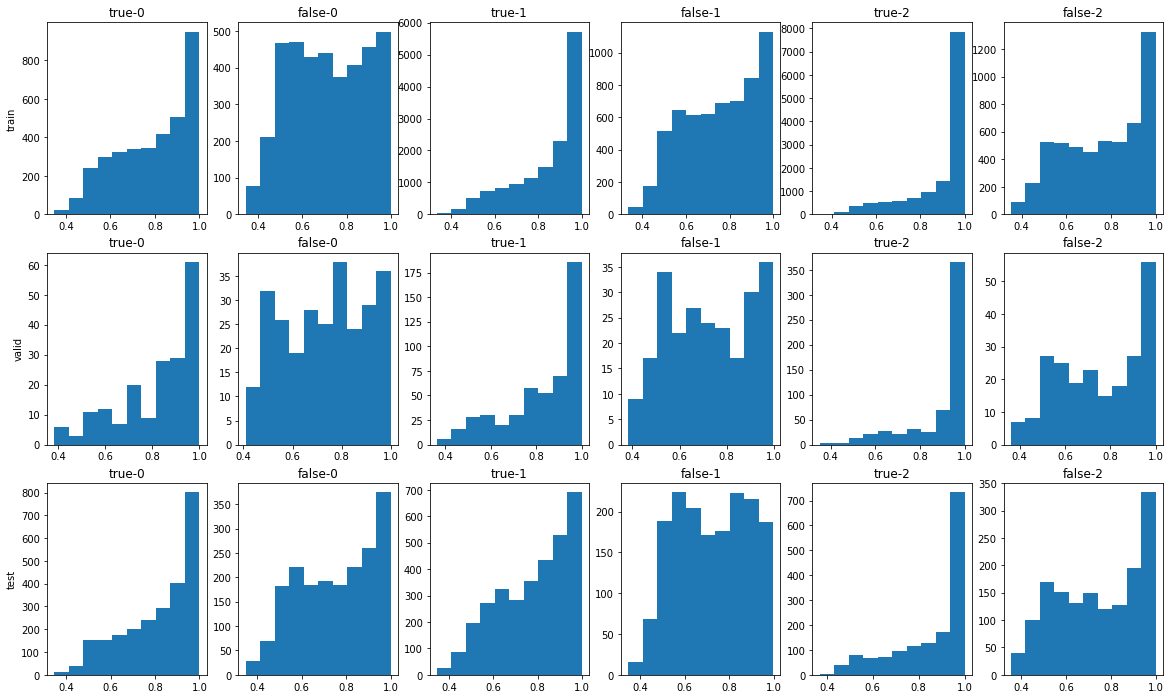

In [23]:
fig, axs = plt.subplots(3, 6, figsize=(20,12))

for i, stage_distr in enumerate(distributions.items()):
    stage, true_false_distr = stage_distr
    true_distr, false_distr = true_false_distr['true'], true_false_distr['false']
    for label in range(3):
        true_hist = axs[i, label*2]
        true_hist.hist(true_distr[label])
        true_hist.set_title(f'true-{label}')
        
        false_hist = axs[i, label*2 + 1]
        false_hist.hist(false_distr[label])
        false_hist.set_title(f'false-{label}')
        
    axs[i, 0].set(ylabel=list(distributions.keys())[i])

In [24]:
print(classification_report(test_targets, test_preds))

              precision    recall  f1-score   support

           0       0.56      0.62      0.59      3972
           1       0.66      0.54      0.59      5937
           2       0.50      0.63      0.56      2375

    accuracy                           0.58     12284
   macro avg       0.57      0.60      0.58     12284
weighted avg       0.60      0.58      0.58     12284



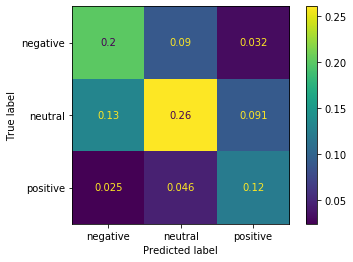

In [25]:
cmp = ConfusionMatrixDisplay(confusion_matrix(test_targets, test_preds, normalize='all'), display_labels=['negative', 'neutral', 'positive']).plot()

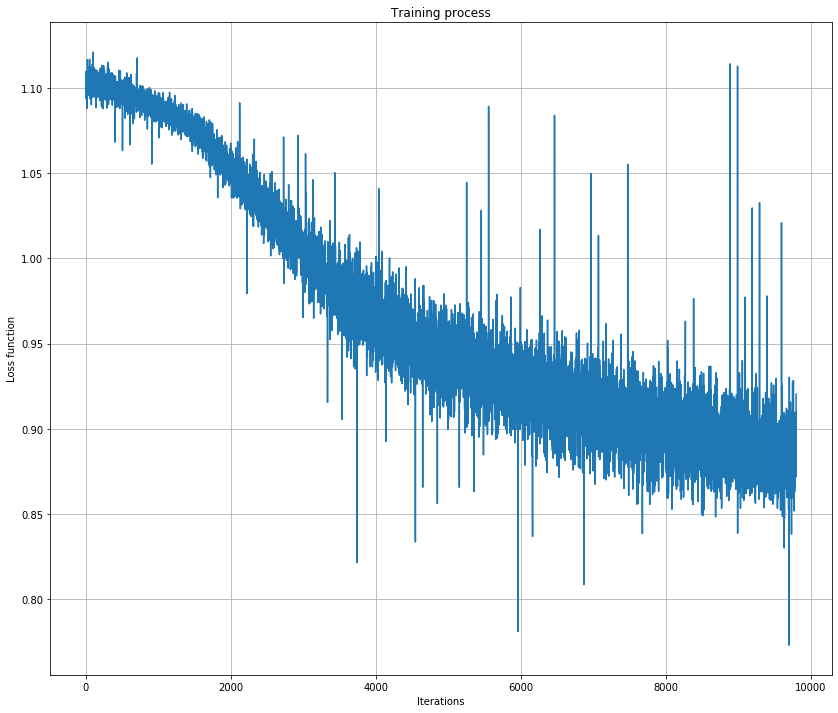

In [26]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

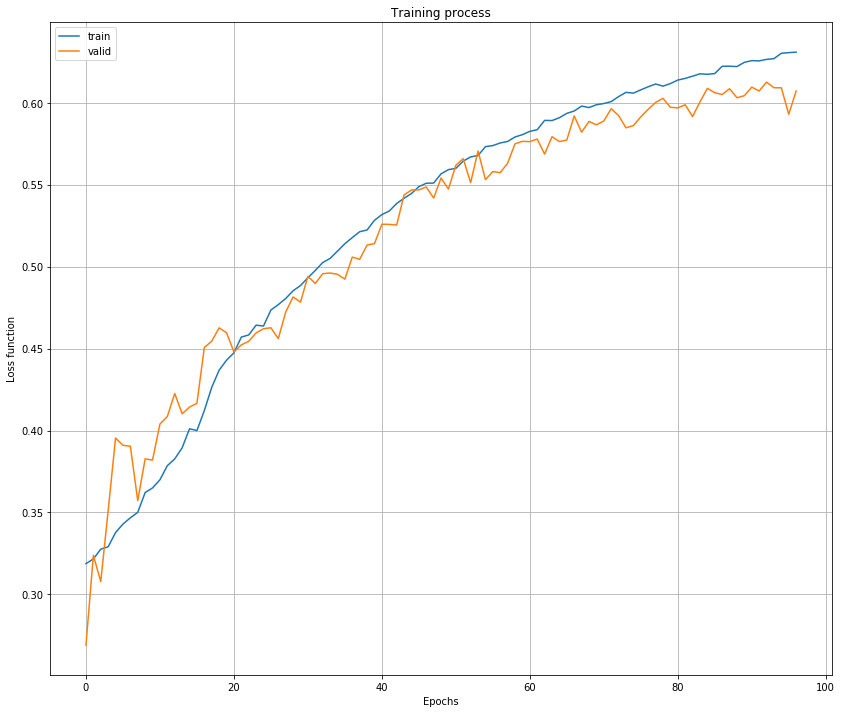

In [27]:
plt.figure(figsize=(14, 12))
plt.plot(f1_train, label='train')
plt.plot(f1_valid, label='valid')
plt.grid()
plt.legend()
plt.title('Training process')
plt.xlabel('Epochs')
plt.ylabel('Loss function');

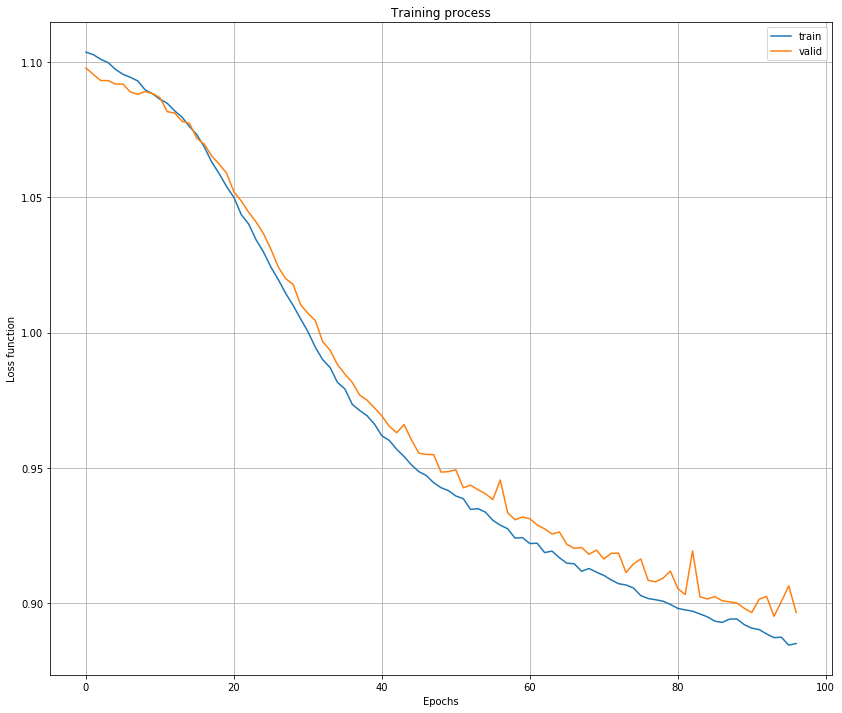

In [28]:
plt.figure(figsize=(14, 12))
plt.plot(t_losses, label='train')
plt.plot(v_losses, label='valid')
plt.grid()
plt.legend()
plt.title('Training process')
plt.xlabel('Epochs')
plt.ylabel('Loss function');

In [29]:
model.eval()
    
test_sentences = [
    'I had bad day yesterday :(',
    'I hate this film',
    'I love how he hates her',
    'This game is cool!!',
    'Today is raining and cold.',
    'He looks pretty ugly'
]

tokenized_sentences = torch.LongTensor([tokenizer(sentence) for sentence in test_sentences]).to('cuda' if torch.cuda.is_available() else 'cpu')
with torch.no_grad():

    pred = model(tokenized_sentences)

In [30]:
pred

tensor([[0.6646, 0.1926, 0.1429],
        [0.4936, 0.3887, 0.1177],
        [0.3500, 0.0590, 0.5910],
        [0.0474, 0.0295, 0.9230],
        [0.2515, 0.5689, 0.1796],
        [0.4152, 0.2111, 0.3737]], device='cuda:0')

In [31]:
import random
from pprint import pprint

pprint(random.sample([(text, label) for text, label in zip(train_dataset['text'], train_dataset['label'])], 10))

[('@user thanks for following me Maite,great to see you Saturday."', 2),
 ("Tomorrow morning I'll tell you what @user and @user talk Purple Line and "
  'the future of the ICC in Maryland. #mdtraffic #moco',
  1),
 ('Both Hernanes and Alex Sandro are expected to start and make their Juventus '
  'debuts on Saturday. (via GdS)',
  2),
 ('I rememeber I was an 8th grader & In a while were about to be Jr\\u2019s '
  'WOW .',
  1),
 ('New York Giants: Game-by-Game Predictions for the 2nd Half of the Season',
  1),
 ('Lingmerth double bogys the 7th falls back to a tie with Dustin Johnson at '
  '-6 #PGAChampionship',
  1),
 ('I was just publicly embarrassed by @user he lowered my Gucci points by like '
  '2 this friendship may be over',
  1),
 ('"While the news channels divulge on the prospect of postponing the hanging '
  'of Yakub, the proceedings may very well have begun by now."',
  1),
 ('Rumourz - Tribute To Fleetwood Mac, Saturday, August 29, 7:30pm Free '
  'Admission! A preview is p

# Выводы
Напишите небольшой отчет о проделанной работе. Что удалось, в чем не уверены, что делать дальше.

Вначале я обучал модель на word2vec эмбеддингах с использованием большого learning rate (0.01). В результате f1-score был довольно низким. Более того, в некоторых случаях какой-то из классов вообще переставал определяться. После этого я перешёл на токенизатор и эмбеддинги берта, дообученного на твитах для определения тональности. После этого и анализа распределения классов я решил попробовать использовать веса для лосса. Также я уменьшил learning rate, т.к. он был слишком большим и выдавал зачастую рандомные результаты на валидации.

Помимо подбора гиперпараметров я немного предобработал текст. В частности, убрал случаи с @user, со словами длиной 1 и немного убрал пунктуацию. В будущем возможно имеет смысл убрать числительные в тексте, потому что по большей части они не несут смысловой нагрузки. Исключением могут быть ситуации со смайликами, например "8)", ":3" и т.д.

Графики показывают, что модель как минимум не переобучилась. На мой взгляд, дальше обучать модель не имеет смысла, поскольку многоразовый запуск показывал примерно те же результаты к 100 эпохе. Тем более при дальнейшем обучении модель начинает давать частые выбросы по валидационному лоссу.

В результате доработки модели мне удалось добиться результата в 0.58. По classification report можно видеть, что классы определяются корректно в примерно 60%, что в свою очередь говорит о не самой плохой предсказательной способности. Более того, если посмотреть на распределение вероятностей мажоритарного класса, то вероятности определения верного класса для всех классов стремятся к единице. В случае с ошибочными результатами уверенность модели распределена почти равномерно. Это может говорить о том, что модель сильно сомневается в определении некорректного класса. Также confusion matrix показывает, что модель немного путает негативные примеры с нейтральными и нейтральные с негативными классами. 

Причина таких метрик и путаниц может быть в том, что в некоторых твитах могут быть положительные и негативные слова. Причём положительные слова сильно увеличивают вероятность в сторону положительного класса. Негативные же слова не вносят такого влияния на определение негативного класса. Более того, при просмотре самих текстов я не всегда понимал, почему определённый твит отнесли к какому-то классу, возможно поэтому модель тоже часто путает классы.

Чтобы улучшить модель, можно попробовать сделать её более сложной, добавив дополнительные слои. Возможно они немного улучшат качество. Вдобавок стоит внимательней проанализировать датасет, придумав более сложную и корректную предобработку (убирать частые мусорные токены, добавить стоп-слова, нормализовать слова и т.д.). Стоит также добавить в токенизацию специальные токены начала и конца предложения, но поскольку это твиты, то возможно это не сильно улучшит модель, но попробовать можно. Для улучшения качества предсказания негативных и положительных классов имеет смысл взять список положительных и негативных слов и заменить эти слова в тексте на специальный токен вроде &lt;pos&gt; и &lt;neg&gt;.